In [1]:
from importlib import reload
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import gan

cuda = torch.cuda.is_available()

print("Cuda: " + str(cuda))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Cuda: True
Cuda: True


In [7]:
latent_dim = 2
loaded_gen = gan.load_model("good_generator_81", layer_width=400, grid_length=9).eval()

for param in loaded_gen.parameters():
    param.requires_grad = False
    
grid_length = 9

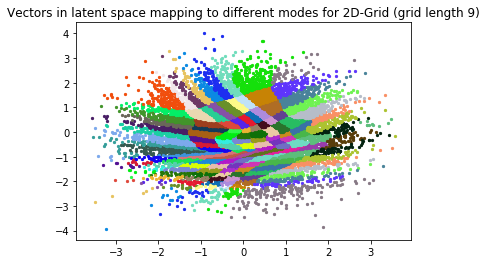

In [8]:
gan.visualize_latent_space(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)

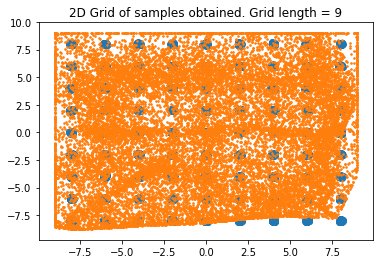

In [9]:
gan.visualize_model(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)

Cuda: True
[Z Class: 40] [Z prime Class: 39]
(array([[-0.8102632 , -0.42065907]], dtype=float32), array([[ 0.5671431, -1.4301983]], dtype=float32))
(1.0, 0.0, 0.5)
(0.5, 0.0, 0.25)
(0.5, 0.25, 0.375)
(0.5, 0.375, 0.4375)
(0.4375, 0.375, 0.40625)
(0.4375, 0.40625, 0.421875)
(0.4375, 0.421875, 0.4296875)
(0.4296875, 0.421875, 0.42578125)
(0.4296875, 0.42578125, 0.427734375)
(0.427734375, 0.42578125, 0.4267578125)
(0.4267578125, 0.42578125, 0.42626953125)
(0.42626953125, 0.42578125, 0.426025390625)
(0.42626953125, 0.426025390625, 0.4261474609375)
(0.4261474609375, 0.426025390625, 0.42608642578125)
(0.4261474609375, 0.42608642578125, 0.426116943359375)
(0.4261474609375, 0.426116943359375, 0.4261322021484375)
(0.4261474609375, 0.4261322021484375, 0.42613983154296875)
(0.42613983154296875, 0.4261322021484375, 0.4261360168457031)
(0.4261360168457031, 0.4261322021484375, 0.4261341094970703)
(0.4261341094970703, 0.4261322021484375, 0.4261331558227539)


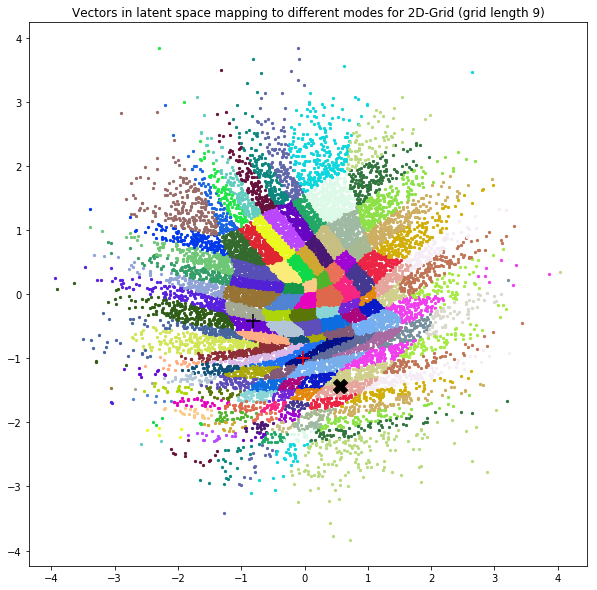

In [42]:
reload(gan)

plt.rcParams['figure.figsize'] = [10, 10]


plt.clf()

# sample a point z at random and record its classification
z = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))
znp = z.cpu().detach().numpy()
z_class = gan.point_to_index(znp, grid_length=grid_length)

# sample a point z_prime at random with a different classification
z_prime = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))
zpnp = z_prime.cpu().detach().numpy()
z_prime_class = gan.point_to_index(zpnp, grid_length=grid_length)
while z_prime_class == z_class:
    z_prime = Variable(Tensor(np.random.normal(0, 1, (1, latent_dim))))
    zpnp = z_prime.cpu().detach().numpy()
    z_prime_class = gan.point_to_index(zpnp, grid_length=grid_length)
    
print("[Z Class: %d] [Z prime Class: %d]" % (z_class, z_prime_class))
print((znp, zpnp))
# display the two points on top of the latent space map

gan.visualize_latent_space(loaded_gen, latent_dim=latent_dim, grid_length=grid_length)

plt.scatter(*zip(*z.cpu().detach().numpy()), c=(0.0, 0.0, 0.0), marker="+", s=200)
plt.scatter(*zip(*z_prime.cpu().detach().numpy()), c=(0.0, 0.0, 0.0), marker="X", s=200)


# compute largest lamb s.t. lamb * z + (1 - lamb) * z_prime
# has a different classification index from z

high, low = 1.0, 0.0
lamb = 0.50
equal_eps = 0.000001
while high > low + equal_eps:
    lamb = (high + low) / 2.0
    print((high, low, lamb))
    test_z = lamb * znp + (1 - lamb) * zpnp
    test_z_class = gan.point_to_index(test_z, grid_length=grid_length)
    if test_z_class == z_class:
        # this means that lamb is too high
        high = lamb
    else:
        # this means that lamb is too low
        low = lamb
best_point = lamb * znp + (1 - lamb) * zpnp

plt.scatter(*zip(*best_point), c = (1.0, 0.0, 0.0), marker="+", s=200)

# sidenote: look into white box adversarial attacks